# **SHAP values**

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT described in the SHAP NIPS paper. 

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap


from tensorflow.keras.models import load_model

# Neccesary info for loading models
import sys
sys.path.insert(0,'../Training')  # add previous directory to path to load constants module
import constants as const
from keras import backend as K
#Pres_mean = 590.292648
#Pres_std = 30315.169840 
Pres_mean = 548.729493
Pres_std = 30275.282659
Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004

DATA_DIR = '../Datasets/'
MODELS_DIR = '../Models/'

TEST_PATH = DATA_DIR + '/Dataset_test_CF.csv'

# Inputs are normalized, but the output of the model is in original units
MODEL_PATH = MODELS_DIR + 'Ptotal_Cp3D.h5'

#SAMPLES = 10_000
SAMPLES = 2_000
#SAMPLES = 500

Load datasets and model, then fit explainer and return SHAP values:

In [46]:
def show_shap_values(test_path, model_path, reduced_size=None):
    
    model = load_model(model_path)

    test_dataset = pd.read_csv(test_path)
    x_res = test_dataset.iloc[:,1:9]
    x_phys = test_dataset[['V', 'theta', 'W']]    
    x_total = pd.concat([x_phys, x_res],axis=1)  # Concatenates along columns
    X_test = x_total
    X_test.columns.values[0:3] = ['V_phys', 'theta_phys', 'W_phys']
    X_test.reset_index(drop=True, inplace=True)

    if reduced_size:
        test_data = X_test.sample(n=reduced_size, replace=False).to_numpy()
    else:
        test_data = X_test.to_numpy()

    explainer = shap.Explainer(model, test_data, feature_names=X_test.columns)
    shap_values = explainer(test_data)

    return shap_values

Index(['V_phys', 'theta_phys', 'W_phys', 'theta', 'nacelle_temperature', 'V',
       'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature',
       'Wind_angle_c'],
      dtype='object')
3767/3767 [==============================] - 2s 421us/step


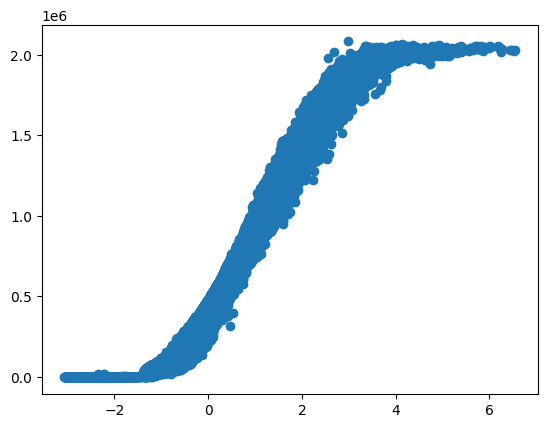

In [47]:
# Inspect data

test_dataset = pd.read_csv(TEST_PATH)
x_res = test_dataset.iloc[:,1:9]
x_phys = test_dataset[['V', 'theta', 'W']]    
x_total = pd.concat([x_phys, x_res],axis=1)  # Concatenates along columns
X_test = x_total
X_test.columns.values[0:3] = ['V_phys', 'theta_phys', 'W_phys']
X_test.reset_index(drop=True, inplace=True)
print(X_test.columns)   

model = load_model(MODEL_PATH)
Pphys_data = model.predict(X_test)

V_data = X_test['V']
#V_data = X_test['V_phys']
plt.scatter(V_data,Pphys_data)

### Explainability analysis

Plots for the vanilla model and dataset.

In [68]:
shap_values = show_shap_values(TEST_PATH, MODEL_PATH, SAMPLES)

# Save shap values
import joblib  # for saving the SHAP values
joblib.dump(shap_values, 'shap_Ptotal.sav')

PermutationExplainer explainer: 2001it [05:40,  5.69it/s]                          


['shap_Ptotal.sav']

In [48]:
import joblib  
# Load shap values
shap_values = joblib.load('shap_Ptotal.sav')

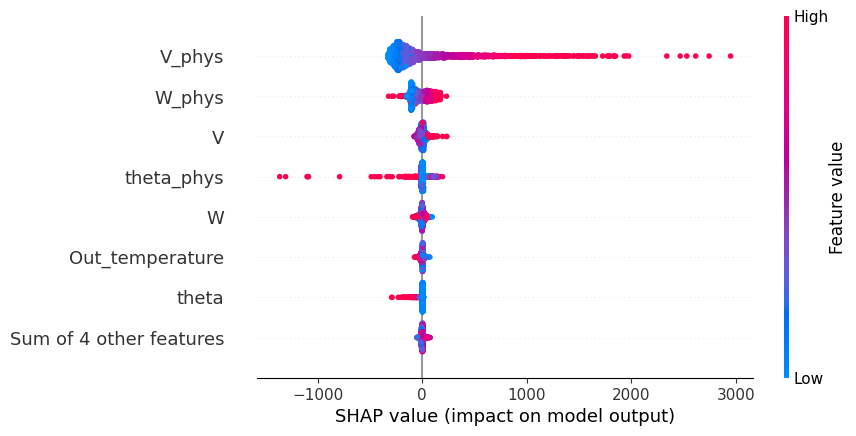

In [49]:
# Removing outliers:
""" shap_values_no_out = shap_values
shap_values_no_out.values = np.clip(shap_values_no_out.values, -500_000, 2000_000)
shap.plots.beeswarm(shap_values_no_out/1000, max_display=10) """
shap.plots.beeswarm(shap_values/1000, max_display=8)


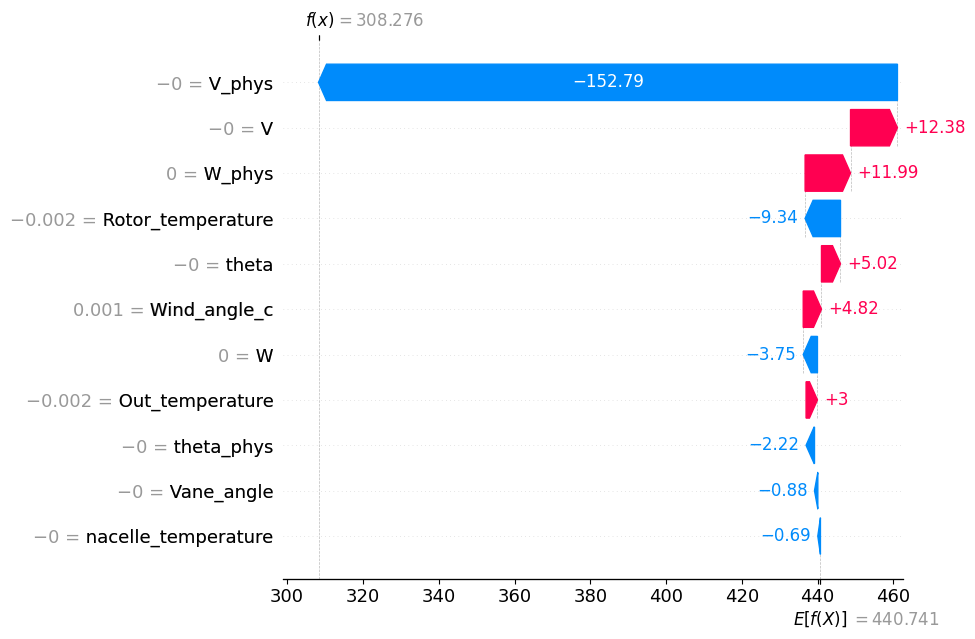

In [50]:
shap.plots.waterfall(shap_values[1]/1000, max_display=20)

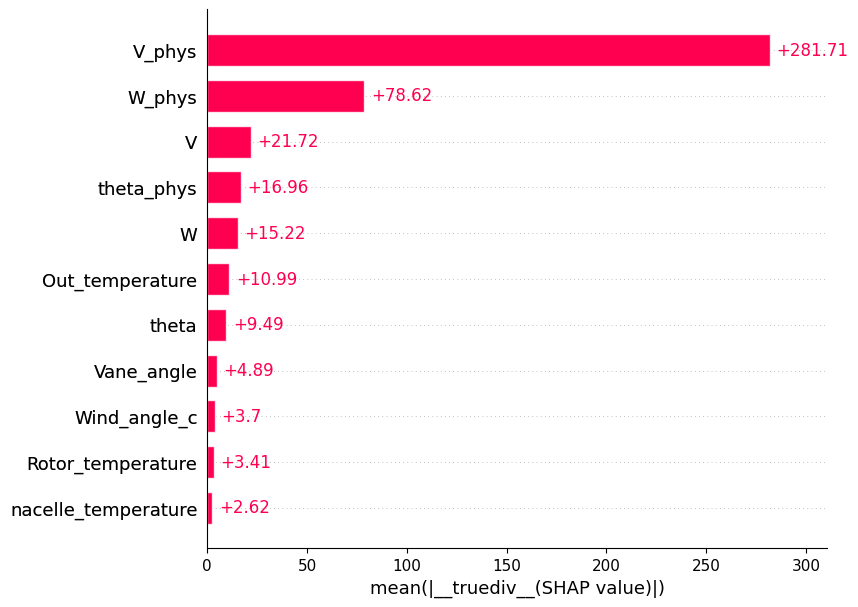

In [51]:
shap.plots.bar(shap_values/1000, max_display=12)

In [52]:
print(shap_values.feature_names)

['V_phys', 'theta_phys', 'W_phys', 'theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']


(2000, 11)
(11,)


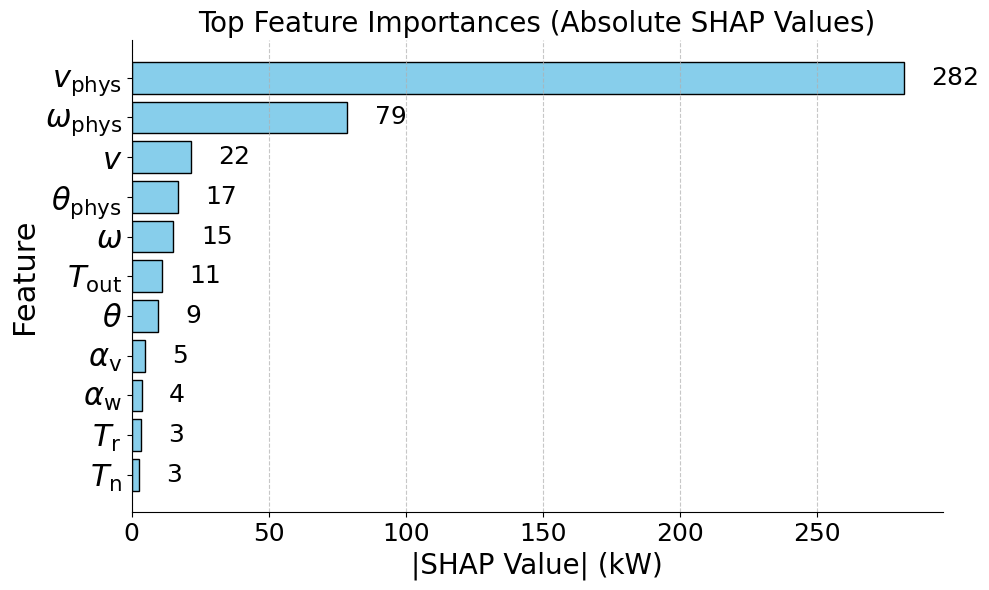

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_values is already defined
shap_values_np = shap_values.values / 1000
print(shap_values_np.shape)

# Compute the mean absolute SHAP values for each feature
shap_values_mean = np.mean(np.abs(shap_values_np), axis=0)
print(shap_values_mean.shape)

# Example feature names (replace with actual feature names)
#features = shap_values.feature_names
# Custom feature names using LaTeX formatting
features = [
    '$v_{\\text{phys}}$', '$\\theta_{\\text{phys}}$', '$\\omega_{\\text{phys}}$', 
    '$\\theta$', '$T_{\\text{n}}$', '$v$', '$\\alpha_{\\text{v}}$', 
    '$T_{\\text{out}}$', '$\\omega$', '$T_{\\text{r}}$', 
    '$\\alpha_{\\text{w}}$'
]

# Combine feature names and SHAP values into a DataFrame
df = pd.DataFrame({'Feature': features, 'SHAP Value': shap_values_mean})

# Sort the DataFrame by absolute SHAP values, from most important to least important
df = df.loc[df['SHAP Value'].abs().sort_values(ascending=True).index]

# Take the top 12 (max_display)
df_top = df.head(12)

# Plotting the bar chart
plt.figure(figsize=(10, 6))

    
# Create horizontal bar plot for top 12 features
bars = plt.barh(df_top['Feature'], df_top['SHAP Value'], color='skyblue', edgecolor='black')

# Add the amplitude values as text to the right of each bar
space_between_bar_and_text = 10  # Increase this value to add more space
for bar, shap_value in zip(bars, df_top['SHAP Value']):
    width = bar.get_width()  # The width of the bar (SHAP value)
    plt.text(width + space_between_bar_and_text, bar.get_y() + bar.get_height() / 2, f'{width:.0f}', 
             va='center', ha='left', fontsize=18, color='black')

# Add labels and title
plt.xlabel('|SHAP Value| (kW)', fontsize=20)
plt.ylabel('Feature', fontsize=22)
plt.title('Top Feature Importances (Absolute SHAP Values)', fontsize=20)

# Customize ticks
plt.xticks(fontsize=18)
plt.yticks(fontsize=22)

# Hide the right spine (border)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Optional: Add a grid for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

(2000,)
3767/3767 [==============================] - 2s 432us/step


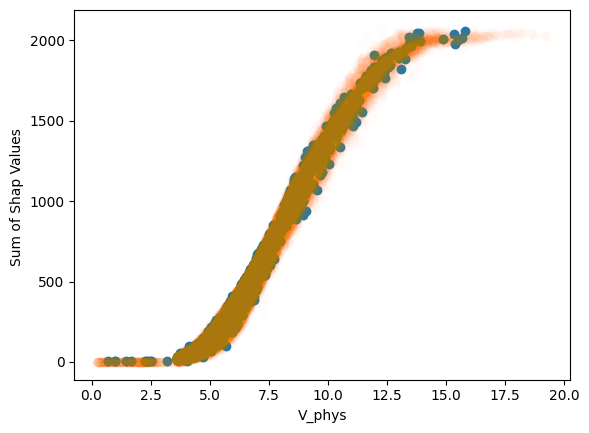

In [54]:
# Scatter plot of sum of all shap values vs variable

# Sum SHAP values for each sample across all features
shap_sum = np.sum(shap_values.values, axis=1)

x_id = shap_values.feature_names.index("V")
xphys_id = shap_values.feature_names.index("V_phys")
print(shap_sum.shape)

P_mean = 444860.879260
P_std = 446349.165241
V_data = shap_values.data[:,x_id]*V_std + V_mean
P_data = P_mean + shap_sum 
plt.scatter(V_data,P_data/1000)
plt.xlabel(shap_values.feature_names[xphys_id])
plt.ylabel("Sum of Shap Values ")
#plt.xlim((-1,1))

Ptotal_test = model.predict(X_test)/1000
V_test = X_test['V']*V_std + V_mean
plt.scatter(V_test,Ptotal_test,alpha=0.01)

plt.show()

['V_phys', 'theta_phys', 'W_phys', 'theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']
(2000,)
3767/3767 [==============================] - 2s 425us/step


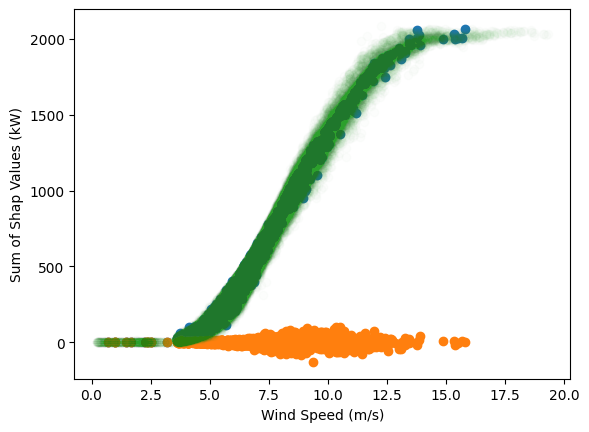

In [55]:
# Scatter plot of sum of phys shap values vs variable

# Sum SHAP values for each sample across phys and res features
print(shap_values.feature_names)
shap_sum_phys = np.sum(shap_values.values[:,:3], axis=1)
shap_sum_res = np.sum(shap_values.values[:,3:], axis=1)

xphys_id = shap_values.feature_names.index("V_phys")
print(shap_sum_phys.shape)

Pphys_mean = 444312.156250
Pphys_std = 445029.968750
V_data = shap_values.data[:,xphys_id]*V_std + V_mean
Pphys_data = Pphys_mean + shap_sum_phys
Pres_data = Pres_mean + shap_sum_res 
plt.scatter(V_data,Pphys_data/1000)
plt.scatter(V_data,Pres_data/1000)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel("Sum of Shap Values (kW)")
#plt.xlim((-1,1))

Ptotal_test = model.predict(X_test)/1000
V_test = X_test['V']*V_std + V_mean
plt.scatter(V_test,Ptotal_test,alpha=0.01)

plt.show()

3767/3767 [==============================] - 2s 432us/step


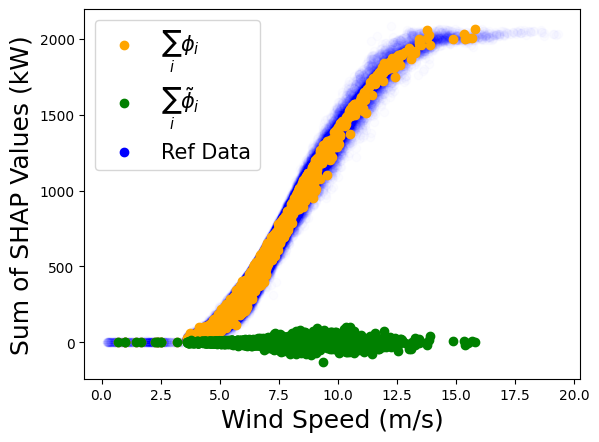

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming shap_values, V_std, V_mean, Pphys_mean, Pres_mean, and model are already defined
shap_sum_phys = np.sum(shap_values.values[:,:3], axis=1)
shap_sum_res = np.sum(shap_values.values[:,3:], axis=1)

# Assuming 'V_phys' is the feature index for wind speed
xphys_id = shap_values.feature_names.index("V_phys")

# Data transformations
Pphys_data = Pphys_mean + shap_sum_phys
Pres_data = Pres_mean + shap_sum_res 
V_data = shap_values.data[:,xphys_id]*V_std + V_mean

# Plotting
plt.scatter(V_data, Pphys_data / 1000, color='orange', zorder=2, label=r'$\sum_i \phi_i$')  # LaTeX formatted label for phi
plt.scatter(V_data, Pres_data / 1000, color='green', zorder=3, label=r'$\sum_i \tilde{\phi}_i$')  # LaTeX formatted label for tilde phi

# Reference data (blue)
Ptotal_test = model.predict(X_test) / 1000
V_test = X_test['V'] * V_std + V_mean
plt.scatter(V_test, Ptotal_test, alpha=0.01, color='blue', zorder=1)

# Add an additional marker for the legend with solid blue
plt.scatter([], [], color='blue', alpha=1, label='Ref Data', zorder=4)  # Opaque blue for legend

# Axis labels
plt.xlabel('Wind Speed (m/s)', fontsize=18)
plt.ylabel("Sum of SHAP Values (kW)", fontsize=18)

# Display the legend with LaTeX formatted labels
plt.legend(fontsize=15)

# Show the plot
plt.show()

3767/3767 [==============================] - 2s 420us/step


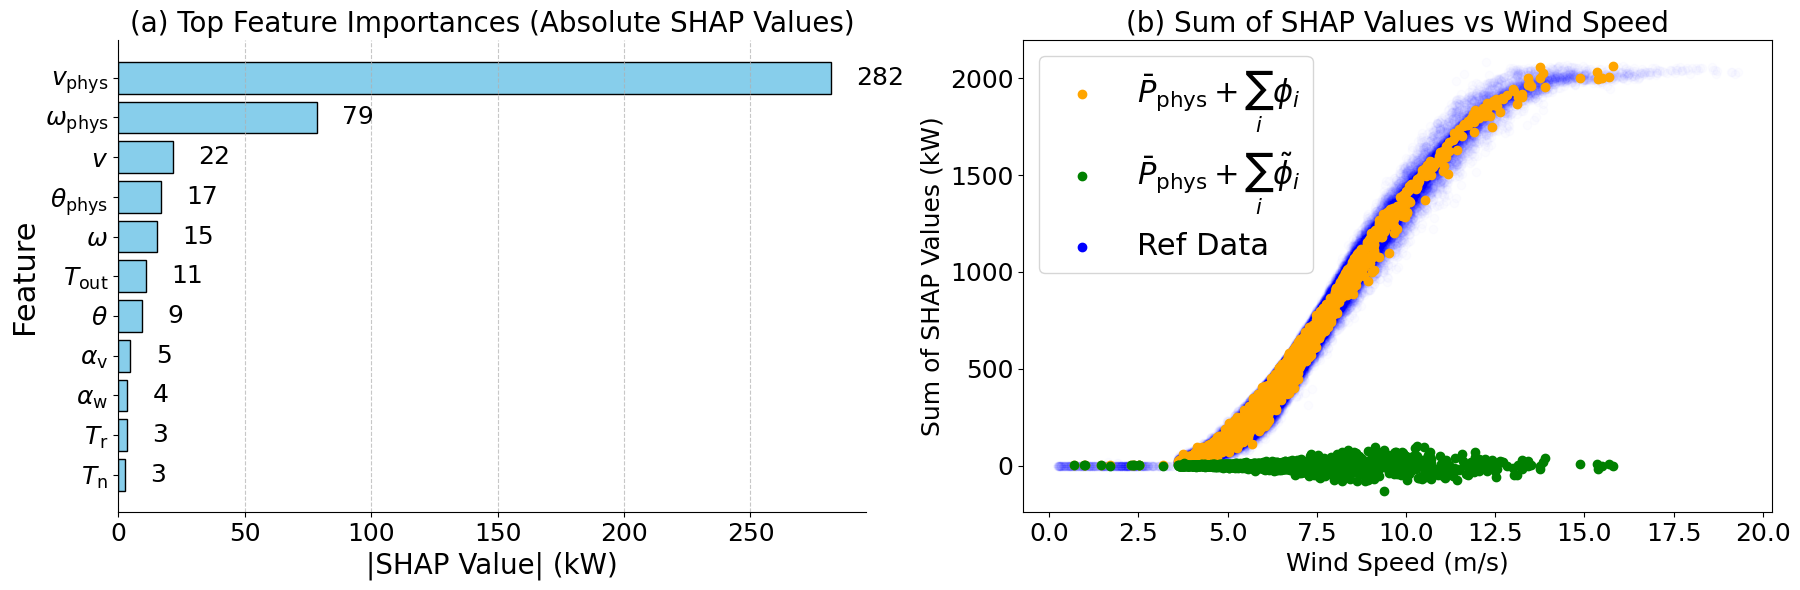

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming shap_values, V_std, V_mean, Pphys_mean, Pres_mean, and model are already defined

# Create the figure with 2 columns and 1 row
fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot 1: Horizontal Bar Plot
shap_values_np = shap_values.values / 1000
shap_values_mean = np.mean(np.abs(shap_values_np), axis=0)

# Custom feature names using LaTeX formatting
features = [
    '$v_{\\text{phys}}$', '$\\theta_{\\text{phys}}$', '$\\omega_{\\text{phys}}$', 
    '$\\theta$', '$T_{\\text{n}}$', '$v$', '$\\alpha_{\\text{v}}$', 
    '$T_{\\text{out}}$', '$\\omega$', '$T_{\\text{r}}$', 
    '$\\alpha_{\\text{w}}$'
]

df = pd.DataFrame({'Feature': features, 'SHAP Value': shap_values_mean})
df = df.loc[df['SHAP Value'].abs().sort_values(ascending=True).index]
df_top = df.head(12)

# Create horizontal bar plot
bars = axs[0].barh(df_top['Feature'], df_top['SHAP Value'], color='skyblue', edgecolor='black')

# Add the amplitude values as text to the right of each bar
space_between_bar_and_text = 10
for bar, shap_value in zip(bars, df_top['SHAP Value']):
    width = bar.get_width()
    axs[0].text(width + space_between_bar_and_text, bar.get_y() + bar.get_height() / 2, f'{width:.0f}', 
                va='center', ha='left', fontsize=18, color='black')

# Set labels and title for plot 1
axs[0].set_xlabel('|SHAP Value| (kW)', fontsize=20)
axs[0].set_ylabel('Feature', fontsize=22)
axs[0].set_title('(a) Top Feature Importances (Absolute SHAP Values)', fontsize=20)

# Customize ticks for plot 1
axs[0].tick_params(axis='both', labelsize=18)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].grid(axis='x', linestyle='--', alpha=0.7)

# Plot 2: Scatter plot of SHAP values vs wind speed
shap_sum_phys = np.sum(shap_values.values[:,:3], axis=1)
shap_sum_res = np.sum(shap_values.values[:,3:], axis=1)

xphys_id = shap_values.feature_names.index("V_phys")
Pphys_data = Pphys_mean + shap_sum_phys
Pres_data = Pres_mean + shap_sum_res 
V_data = shap_values.data[:,xphys_id]*V_std + V_mean

# Plot the scatter plots
axs[1].scatter(V_data, Pphys_data / 1000, color='orange', zorder=2, label=r'$\bar{P}_\text{phys}+\sum_i \phi_i$')
axs[1].scatter(V_data, Pres_data / 1000, color='green', zorder=3, label=r'$\bar{P}_\text{phys}+\sum_i \tilde{\phi}_i$')
#axs[1].scatter(V_data, Pphys_data / 1000, color='orange', zorder=2, label=r'$\phi$')
#axs[1].scatter(V_data, Pres_data / 1000, color='green', zorder=3, label=r'$\tilde{\phi}$')

# Reference data (blue)
Ptotal_test = model.predict(X_test) / 1000
V_test = X_test['V'] * V_std + V_mean
axs[1].scatter(V_test, Ptotal_test, alpha=0.01, color='blue', zorder=1)

# Add an additional marker for the legend with solid blue
axs[1].scatter([], [], color='blue', alpha=1, label='Ref Data', zorder=4)

# Set labels and title for plot 2
axs[1].set_xlabel('Wind Speed (m/s)', fontsize=18)
axs[1].set_ylabel("Sum of SHAP Values (kW)", fontsize=18)
axs[1].set_title('(b) Sum of SHAP Values vs Wind Speed', fontsize=20)

# Display the legend for plot 2
axs[1].legend(fontsize=22)

# Customize ticks for plot 2
axs[1].tick_params(axis='both', labelsize=18)

# Adjust the layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()

['V_phys', 'theta_phys', 'W_phys', 'theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']
(2000,)
3767/3767 [==============================] - 1s 338us/step


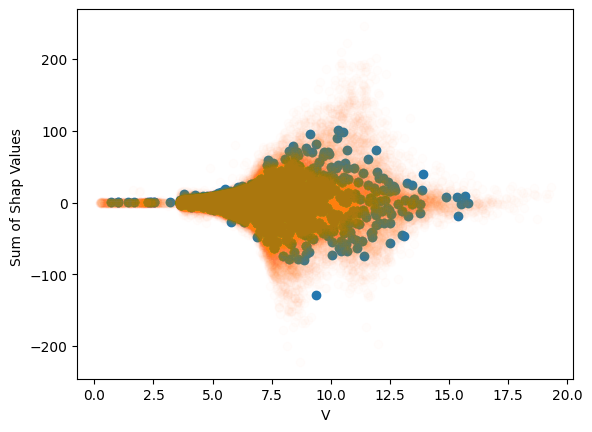

In [18]:
# Scatter plot of sum of res shap values vs V

# Sum SHAP values for each sample across phys and res features
print(shap_values.feature_names)
shap_sum_res = np.sum(shap_values.values[:,3:], axis=1)

x_id = shap_values.feature_names.index("V")
print(shap_sum_res.shape)

V_data = shap_values.data[:,x_id]*V_std + V_mean
Pres_data = Pres_mean + shap_sum_res 
plt.scatter(V_data,Pres_data/1000)
plt.xlabel(shap_values.feature_names[x_id])
plt.ylabel("Sum of Shap Values ")
#plt.xlim((-1,1))

Pres_model = load_model('../Models/Pres_Cp3D_CF.h5')
Pres_test = (Pres_model.predict(x_res)*Pres_std+Pres_mean)/1000
V_test = X_test['V']*V_std + V_mean
plt.scatter(V_test,Pres_test,alpha=0.01)

plt.show()

['V_phys', 'theta_phys', 'W_phys', 'theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']
(2000,)
3767/3767 [==============================] - 1s 333us/step


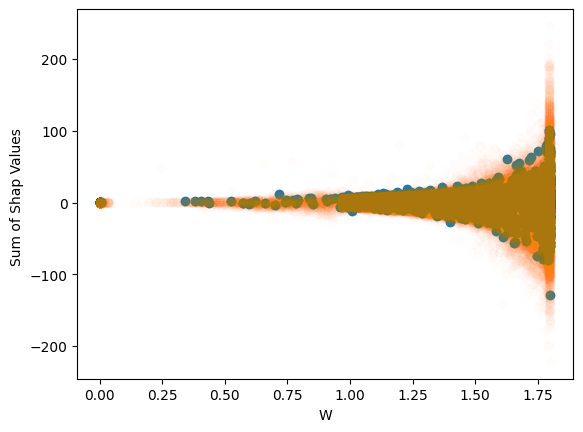

In [60]:
# Scatter plot of sum of res shap values vs W

# Sum SHAP values for each sample across phys and res features
print(shap_values.feature_names)
shap_sum_res = np.sum(shap_values.values[:,3:], axis=1)

x_id = shap_values.feature_names.index("W")
print(shap_sum_res.shape)

W_mean = 1.362470
W_std = 0.318853
W_data = shap_values.data[:,x_id]*W_std + W_mean
Pres_data = Pres_mean + shap_sum_res 
plt.scatter(W_data,Pres_data/1000)
plt.xlabel(shap_values.feature_names[x_id])
plt.ylabel("Sum of Shap Values ")
#plt.xlim((-1,1))

Pres_model = load_model('../Models/Pres_Cp3D_CF.h5')
Pres_test = (Pres_model.predict(x_res)*Pres_std+Pres_mean)/1000
W_test = X_test['W']*W_std + W_mean
plt.scatter(W_test,Pres_test,alpha=0.01)

plt.show()

(2000, 11)
(2000, 1)
(2000, 11)
['V_phys', 'theta_phys', 'W_phys', 'theta', 'nacelle_temperature', 'V', 'Vane_angle', 'Out_temperature', 'W', 'Rotor_temperature', 'Wind_angle_c']


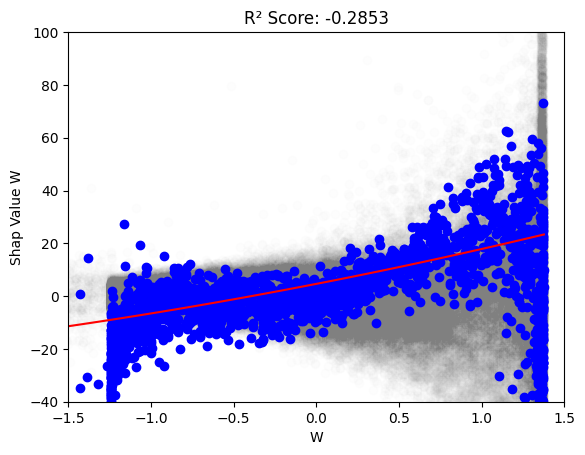

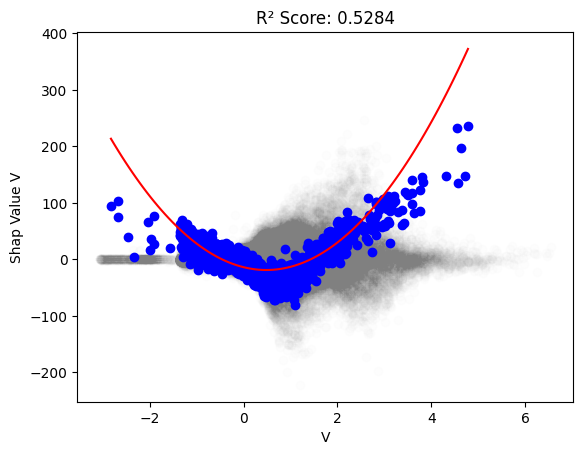

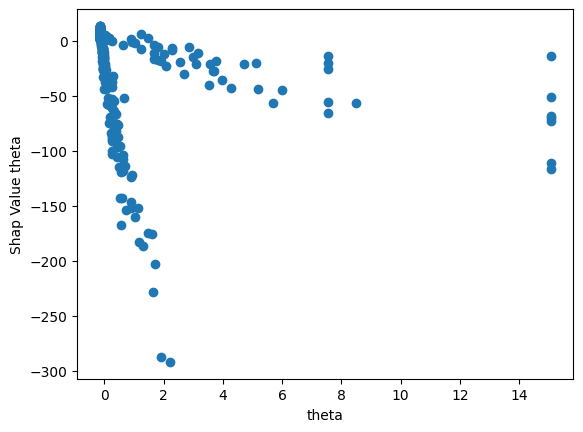

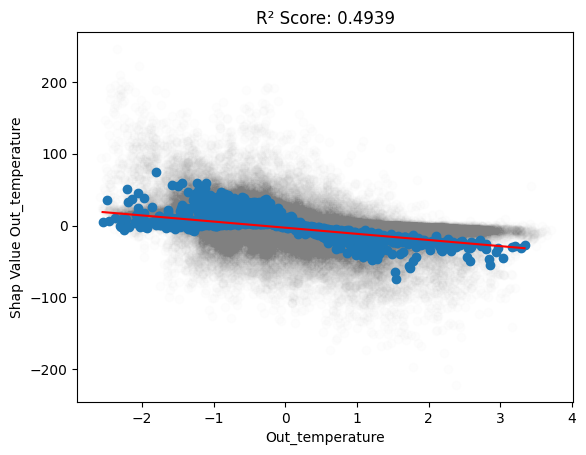

In [61]:
# Scatter plot of shap value vs variable

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.metrics import r2_score

print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(shap_values.data.shape)
print(shap_values.feature_names)

# W
#W_test = X_test['W']*W_std + W_mean
W_test = X_test['W']
plt.scatter(W_test,Pres_test,color='gray',alpha=0.01)

x_id = shap_values.feature_names.index("W")
y_id = shap_values.feature_names.index("W")
plt.scatter(shap_values.data[:,x_id],shap_values.values[:,y_id]/1000,color='blue', label='Data Points')
plt.xlabel(shap_values.feature_names[x_id])
plt.ylabel("Shap Value "+shap_values.feature_names[y_id])

x = shap_values.data[:,x_id]
y = shap_values.values[:,y_id]/1000
poly = PolynomialFeatures(degree=2)
x = x.reshape(-1, 1)
x_poly = poly.fit_transform(x)
model = LinearRegression()
ransac = RANSACRegressor(estimator=model, random_state=42)
ransac.fit(x_poly, y)
line_x = np.linspace(min(x), max(x), 100).reshape(-1, 1)
line_x_poly = poly.transform(line_x)
line_y = ransac.predict(line_x_poly)
plt.plot(line_x, line_y, color='red', label='RANSAC Polynomial Fit')
r2 = r2_score(y, ransac.predict(x_poly))
plt.title(f'R² Score: {r2:.4f}')

plt.xlim((-1.5,1.5))
plt.ylim((-40,100))
plt.show()

# V
#V_test = X_test['V']*V_std + V_mean
V_test = X_test['V']
plt.scatter(V_test,Pres_test,color='gray',alpha=0.01)

x_id = shap_values.feature_names.index("V")
y_id = shap_values.feature_names.index("V")
plt.scatter(shap_values.data[:,x_id],shap_values.values[:,y_id]/1000,color='blue', label='Data Points')
plt.xlabel(shap_values.feature_names[x_id])
plt.ylabel("Shap Value "+shap_values.feature_names[y_id])

x = shap_values.data[:,x_id]
y = shap_values.values[:,y_id]/1000
poly = PolynomialFeatures(degree=2)
x = x.reshape(-1, 1)
x_poly = poly.fit_transform(x)
model = LinearRegression()
ransac = RANSACRegressor(estimator=model, random_state=42)
ransac.fit(x_poly, y)
line_x = np.linspace(min(x), max(x), 100).reshape(-1, 1)
line_x_poly = poly.transform(line_x)
line_y = ransac.predict(line_x_poly)
plt.plot(line_x, line_y, color='red', label='RANSAC Polynomial Fit')
r2 = r2_score(y, ransac.predict(x_poly))
plt.title(f'R² Score: {r2:.4f}')

plt.show()

# theta
x_id = shap_values.feature_names.index("theta")
y_id = shap_values.feature_names.index("theta")
plt.scatter(shap_values.data[:,x_id],shap_values.values[:,y_id]/1000)
plt.xlabel(shap_values.feature_names[x_id])
plt.ylabel("Shap Value "+shap_values.feature_names[y_id])
plt.show()

# Out temperature
#T_test = X_test['Out_temperature']*T_std + T_mean
T_test = X_test['Out_temperature']
plt.scatter(T_test,Pres_test,color='gray',alpha=0.01)

x_id = shap_values.feature_names.index("Out_temperature")
y_id = shap_values.feature_names.index("Out_temperature")
plt.scatter(shap_values.data[:,x_id],shap_values.values[:,y_id]/1000)
plt.xlabel(shap_values.feature_names[x_id])
plt.ylabel("Shap Value "+shap_values.feature_names[y_id])

x = shap_values.data[:,x_id]
y = shap_values.values[:,y_id]/1000
poly = PolynomialFeatures(degree=1)
x = x.reshape(-1, 1)
x_poly = poly.fit_transform(x)
model = LinearRegression()
ransac = RANSACRegressor(estimator=model, random_state=42)
ransac.fit(x_poly, y)
line_x = np.linspace(min(x), max(x), 100).reshape(-1, 1)
line_x_poly = poly.transform(line_x)
line_y = ransac.predict(line_x_poly)
plt.plot(line_x, line_y, color='red', label='RANSAC Polynomial Fit')
r2 = r2_score(y, ransac.predict(x_poly))
plt.title(f'R² Score: {r2:.4f}')

plt.show()


In [62]:
def plot_shap_scatter(shap_values, feature_name,xlims=None,ylims=None):
    # Get the index of the feature
    feature_id = shap_values.feature_names.index(feature_name)
            
    # Extract SHAP values and feature data for the specific feature
    shap_vals = shap_values.values[:, feature_id]/1000 # in kW units
    feature_vals = shap_values.data[:, feature_id]

    threshold = 3
    # Calculate default xlims if not provided
    if xlims is None:
        x_mean, x_std = np.mean(feature_vals), np.std(feature_vals)
        xlims = [x_mean - threshold* x_std, x_mean + threshold* x_std]

    # Calculate default ylims if not provided
    if ylims is None:
        y_mean, y_std = np.mean(shap_vals), np.std(shap_vals)
        ylims = [y_mean - threshold* y_std, y_mean + threshold* y_std]

    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_vals, shap_vals, alpha=0.6, edgecolor='k')
    plt.title(f'SHAP Values for {feature_name}')
    plt.xlabel(f'{feature_name} value')
    plt.ylabel('SHAP value (kW)')
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.grid(True)
    plt.show()

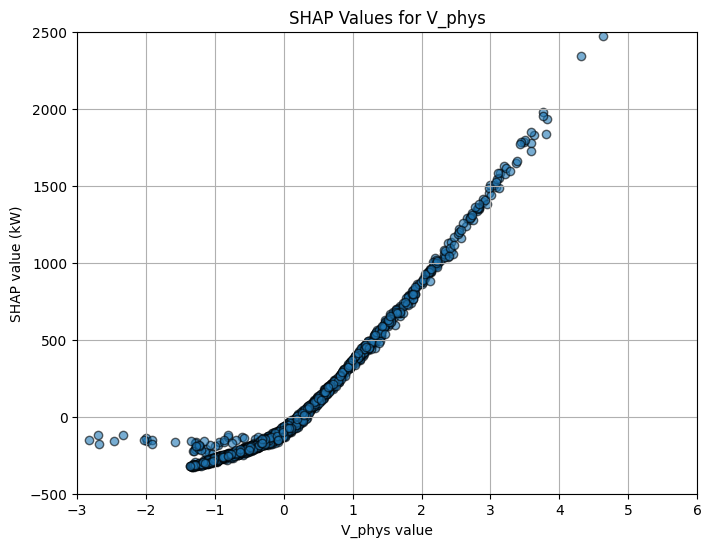

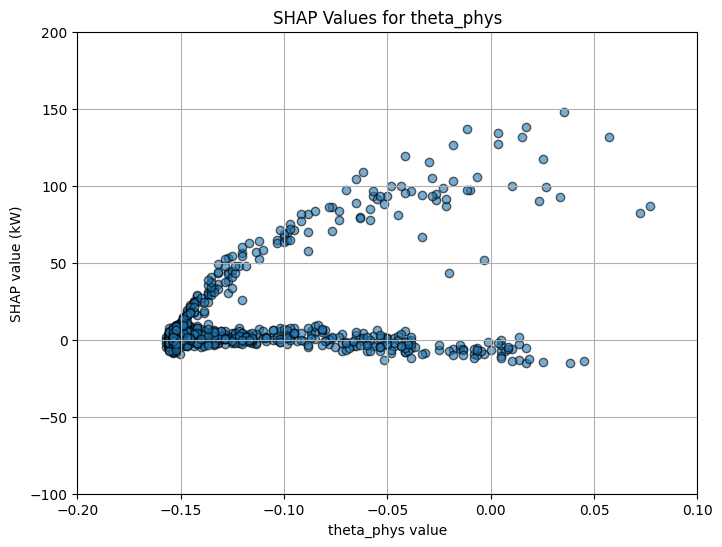

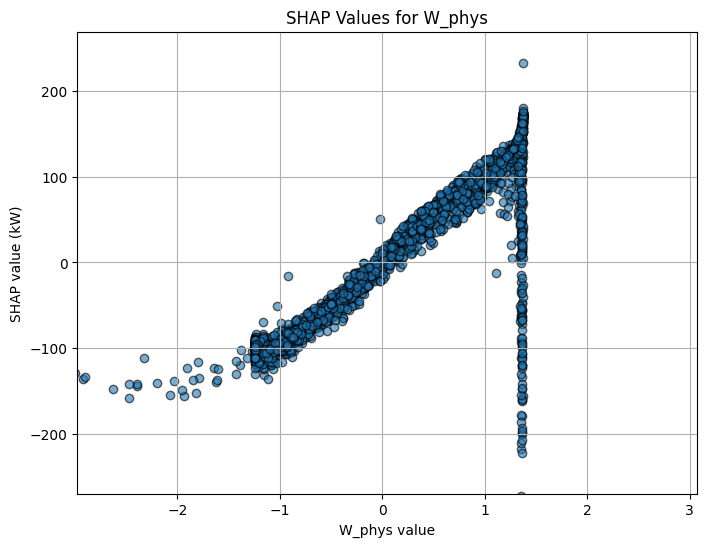

In [63]:
plot_shap_scatter(shap_values=shap_values,feature_name='V_phys',xlims=[-3,6],ylims=[-500,2500])
plot_shap_scatter(shap_values=shap_values,feature_name='theta_phys',xlims=[-0.2,0.1],ylims=[-100,200])
plot_shap_scatter(shap_values=shap_values,feature_name='W_phys')

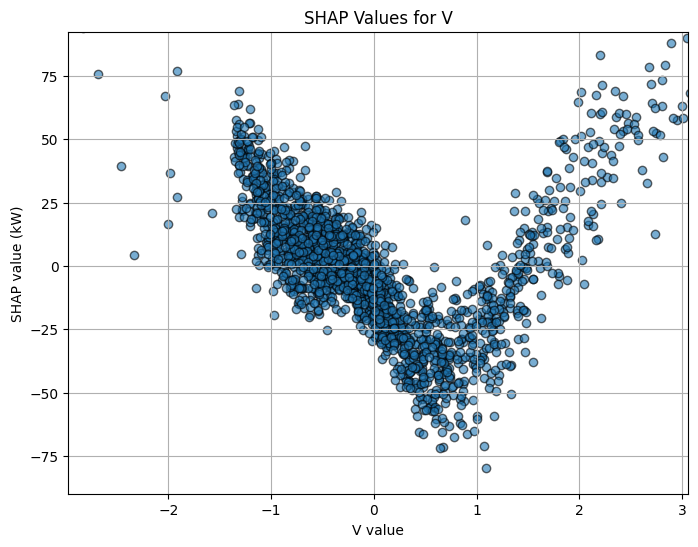

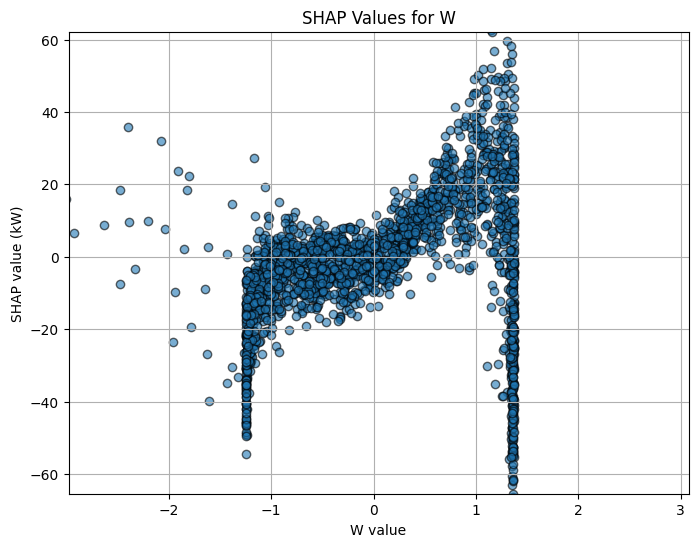

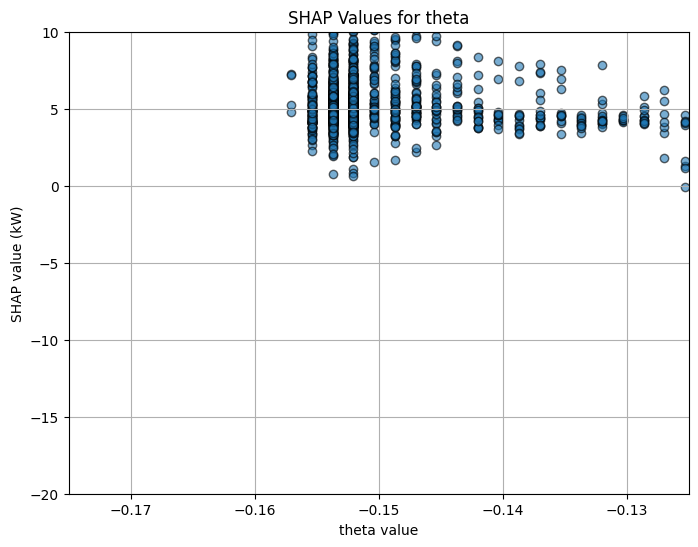

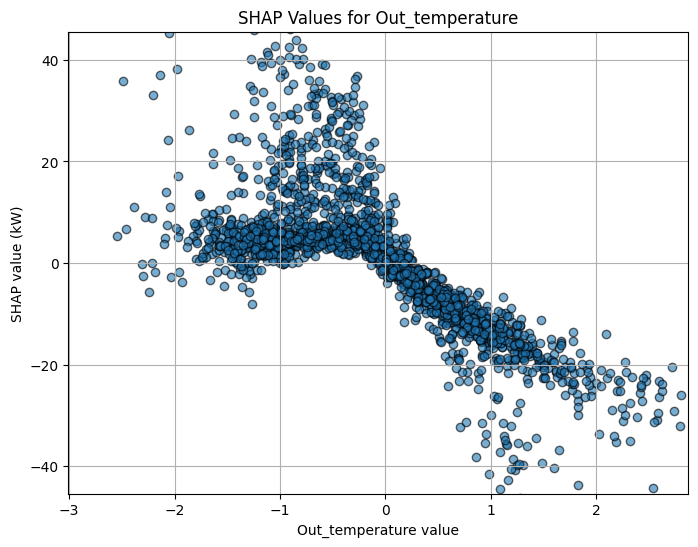

In [64]:
plot_shap_scatter(shap_values=shap_values,feature_name='V')
plot_shap_scatter(shap_values=shap_values,feature_name='W')
#plot_shap_scatter(shap_values=shap_values,feature_name='theta',xlims=[-0.2,0.0],ylims=[-20,10])
plot_shap_scatter(shap_values=shap_values,feature_name='theta',xlims=[-0.175,-0.125],ylims=[-20,10])
plot_shap_scatter(shap_values=shap_values,feature_name='Out_temperature')


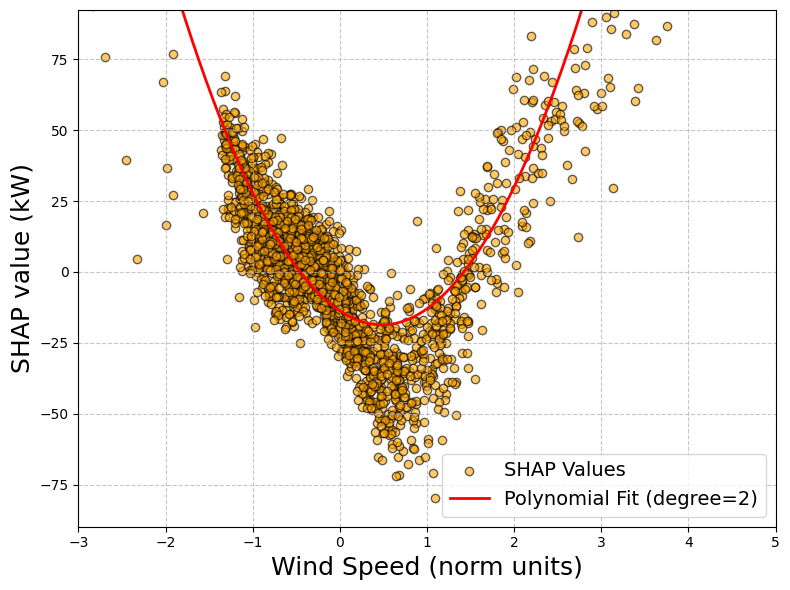

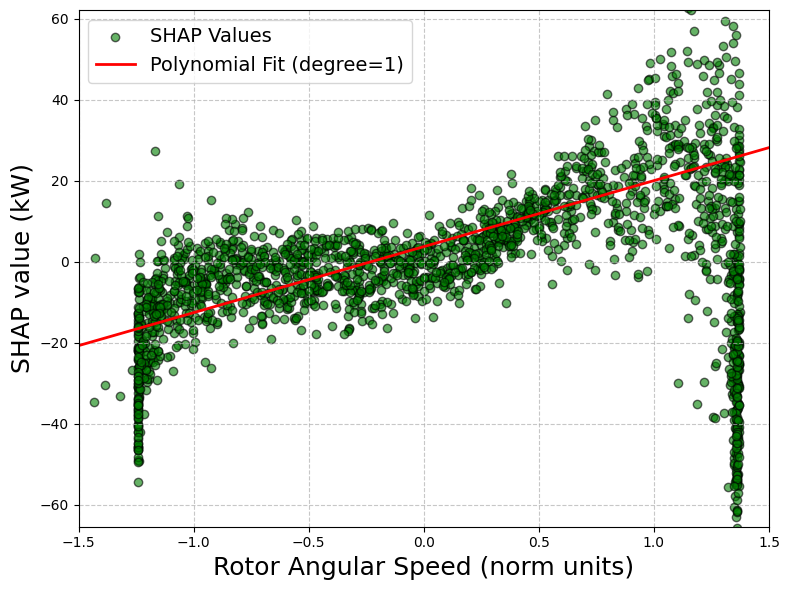

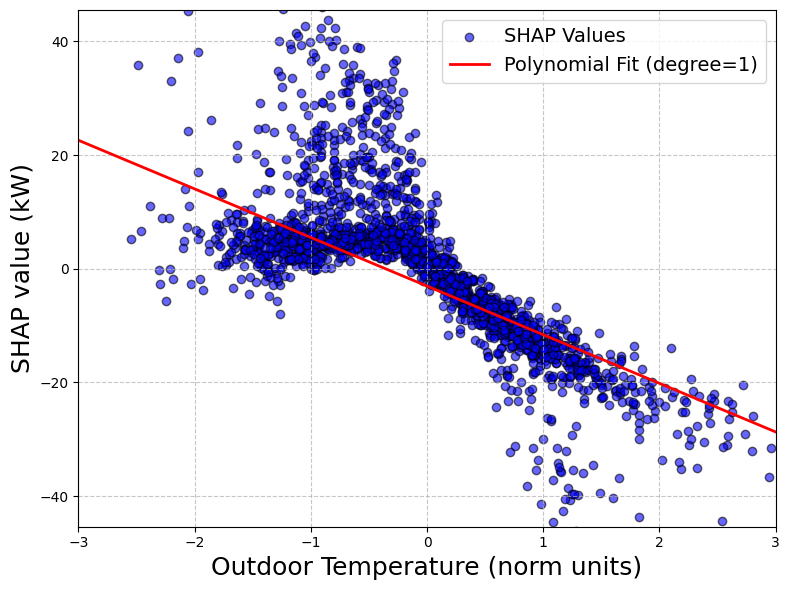

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_shap_scatter_with_ransac(shap_values, feature_name, x_label, poly_degree, xlims=None, ylims=None, color='skyblue'):
    # Obtener el índice de la característica
    feature_id = shap_values.feature_names.index(feature_name)
    
    # Extraer los valores SHAP y los datos de la característica
    shap_vals = shap_values.values[:, feature_id] / 1000  # en unidades de kW
    feature_vals = shap_values.data[:, feature_id].reshape(-1, 1)  # reshape para compatibilidad con sklearn

    threshold = 3
    # Calcular límites por defecto si no se proporcionan
    if xlims is None:
        x_mean, x_std = np.mean(feature_vals), np.std(feature_vals)
        xlims = [x_mean - threshold * x_std, x_mean + threshold * x_std]

    if ylims is None:
        y_mean, y_std = np.mean(shap_vals), np.std(shap_vals)
        ylims = [y_mean - threshold * y_std, y_mean + threshold * y_std]

    # RANSAC para ajuste polinómico
    ransac = make_pipeline(PolynomialFeatures(degree=poly_degree), RANSACRegressor(random_state=42))
    ransac.fit(feature_vals, shap_vals)

    # Generar valores para la curva ajustada
    x_fit = np.linspace(xlims[0], xlims[1], 500).reshape(-1, 1)  # Puntos para el rango de X
    y_fit = ransac.predict(x_fit)  # Predicciones del ajuste RANSAC

    # Crear el gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_vals, shap_vals, alpha=0.6, edgecolor='k', color=color, label='SHAP Values')
    #plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'RANSAC Fit (degree={poly_degree})')
    plt.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Polynomial Fit (degree={poly_degree})')

    # Configurar etiquetas
    plt.xlabel(f'{x_label} (norm units)', fontsize=18)
    plt.ylabel('SHAP value (kW)', fontsize=18)
    
    # Configurar límites y cuadrícula
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

# Generar gráficos para las tres variables
plot_shap_scatter_with_ransac(
    shap_values=shap_values, 
    feature_name='V', 
    x_label='Wind Speed', 
    poly_degree=2, 
    xlims=[-3, 5], 
    color='orange'
)

plot_shap_scatter_with_ransac(
    shap_values=shap_values, 
    feature_name='W', 
    x_label='Rotor Angular Speed', 
    poly_degree=1, 
    xlims=[-1.5, 1.5], 
    color='green'
)

plot_shap_scatter_with_ransac(
    shap_values=shap_values, 
    feature_name='Out_temperature', 
    x_label='Outdoor Temperature', 
    poly_degree=1, 
    xlims=[-3, 3], 
    color='blue'
)

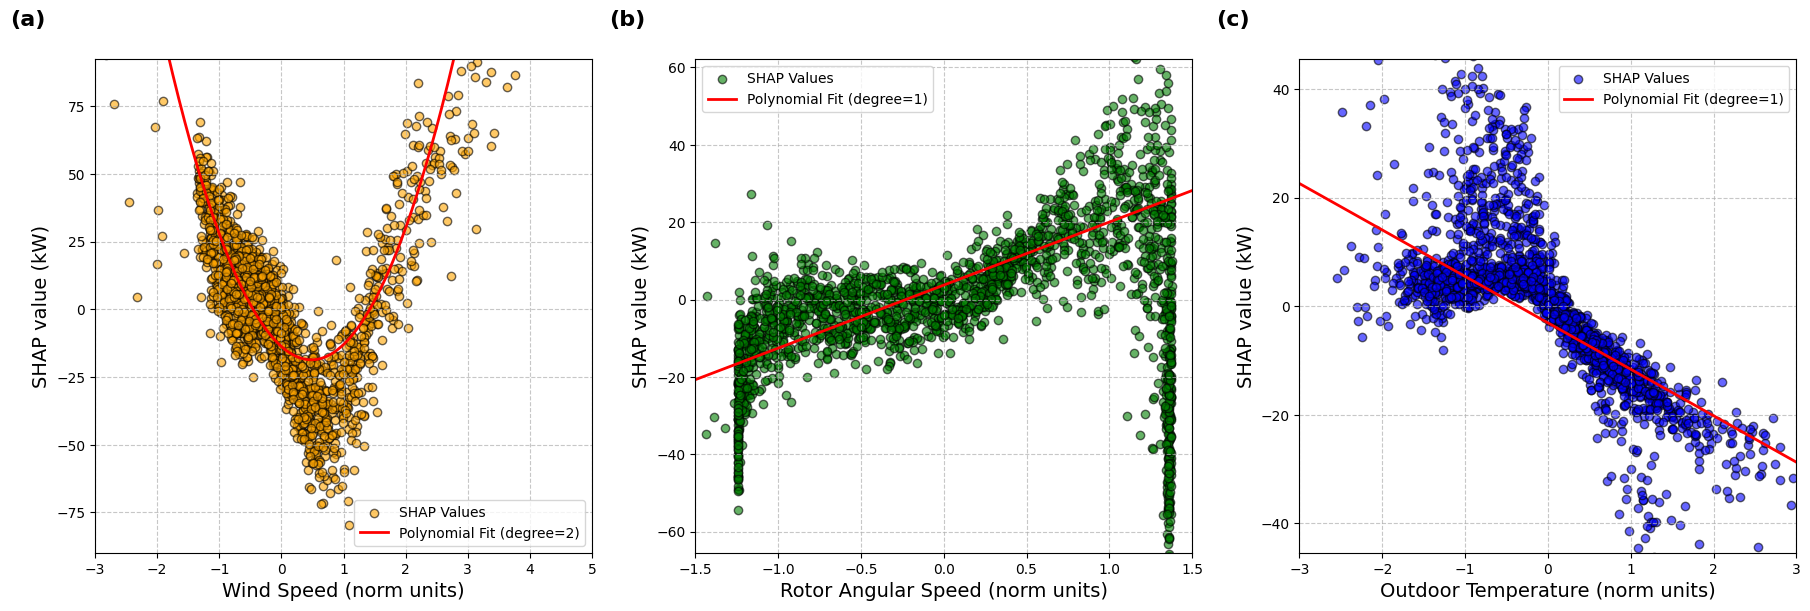

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_shap_scatter_with_ransac(ax, shap_values, feature_name, x_label, poly_degree, xlims=None, ylims=None, color='skyblue', label=None):
    # Get the index of the feature
    feature_id = shap_values.feature_names.index(feature_name)
    
    # Extract SHAP values and feature data for the specific feature
    shap_vals = shap_values.values[:, feature_id] / 1000  # Convert to kW units
    feature_vals = shap_values.data[:, feature_id].reshape(-1, 1)  # Reshape for sklearn compatibility

    threshold = 3
    # Calculate default x-axis limits if not provided
    if xlims is None:
        x_mean, x_std = np.mean(feature_vals), np.std(feature_vals)
        xlims = [x_mean - threshold * x_std, x_mean + threshold * x_std]

    # Calculate default y-axis limits if not provided
    if ylims is None:
        y_mean, y_std = np.mean(shap_vals), np.std(shap_vals)
        ylims = [y_mean - threshold * y_std, y_mean + threshold * y_std]

    # Apply RANSAC for polynomial fitting
    ransac = make_pipeline(PolynomialFeatures(degree=poly_degree), RANSACRegressor(random_state=42))
    ransac.fit(feature_vals, shap_vals)

    # Generate values for the fitted curve
    x_fit = np.linspace(xlims[0], xlims[1], 500).reshape(-1, 1)  # Points over the x-axis range
    y_fit = ransac.predict(x_fit)  # Predictions from the RANSAC fit

    # Create the scatter plot and fitted curve
    ax.scatter(feature_vals, shap_vals, alpha=0.6, edgecolor='k', color=color, label='SHAP Values')
    ax.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Polynomial Fit (degree={poly_degree})')

    # Configure labels
    ax.set_xlabel(f'{x_label} (norm units)', fontsize=14)
    ax.set_ylabel('SHAP value (kW)', fontsize=14)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=10)
    if label:
        ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Create a figure with subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Generate plots with labels
plot_shap_scatter_with_ransac(
    ax=axes[0], 
    shap_values=shap_values, 
    feature_name='V', 
    x_label='Wind Speed', 
    poly_degree=2, 
    xlims=[-3, 5], 
    color='orange',
    label='(a)'
)

plot_shap_scatter_with_ransac(
    ax=axes[1], 
    shap_values=shap_values, 
    feature_name='W', 
    x_label='Rotor Angular Speed', 
    poly_degree=1, 
    xlims=[-1.5, 1.5], 
    color='green',
    label='(b)'
)

plot_shap_scatter_with_ransac(
    ax=axes[2], 
    shap_values=shap_values, 
    feature_name='Out_temperature', 
    x_label='Outdoor Temperature', 
    poly_degree=1, 
    xlims=[-3, 3], 
    color='blue',
    label='(c)'
)

# Display the complete figure
plt.show()

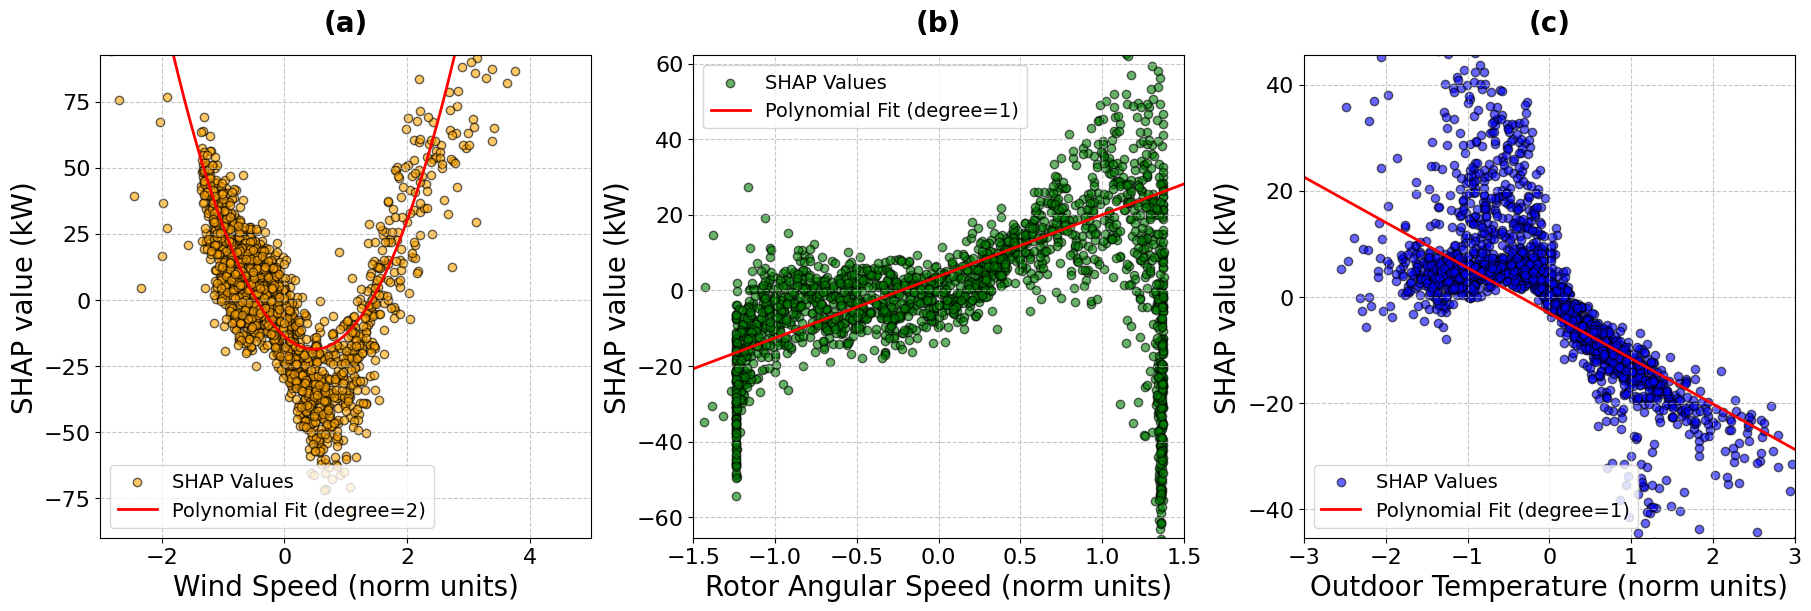

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_shap_scatter_with_ransac(ax, shap_values, feature_name, x_label, poly_degree, xlims=None, ylims=None, color='skyblue', label=None):
    # Get the index of the feature
    feature_id = shap_values.feature_names.index(feature_name)
    
    # Extract SHAP values and feature data for the specific feature
    shap_vals = shap_values.values[:, feature_id] / 1000  # Convert to kW units
    feature_vals = shap_values.data[:, feature_id].reshape(-1, 1)  # Reshape for sklearn compatibility

    threshold = 3
    # Calculate default x-axis limits if not provided
    if xlims is None:
        x_mean, x_std = np.mean(feature_vals), np.std(feature_vals)
        xlims = [x_mean - threshold * x_std, x_mean + threshold * x_std]

    # Calculate default y-axis limits if not provided
    if ylims is None:
        y_mean, y_std = np.mean(shap_vals), np.std(shap_vals)
        ylims = [y_mean - threshold * y_std, y_mean + threshold * y_std]

    # Apply RANSAC for polynomial fitting
    ransac = make_pipeline(PolynomialFeatures(degree=poly_degree), RANSACRegressor(random_state=42))
    ransac.fit(feature_vals, shap_vals)

    # Generate values for the fitted curve
    x_fit = np.linspace(xlims[0], xlims[1], 500).reshape(-1, 1)  # Points over the x-axis range
    y_fit = ransac.predict(x_fit)  # Predictions from the RANSAC fit

    # Create the scatter plot and fitted curve
    ax.scatter(feature_vals, shap_vals, alpha=0.6, edgecolor='k', color=color, label='SHAP Values')
    ax.plot(x_fit, y_fit, color='red', linewidth=2, label=f'Polynomial Fit (degree={poly_degree})')

    # Configure labels
    ax.set_xlabel(f'{x_label} (norm units)', fontsize=20)
    ax.set_ylabel('SHAP value (kW)', fontsize=20)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=14)
    if label:
        # Place the subplot label centered above the plot
        ax.text(0.5, 1.05, label, transform=ax.transAxes, fontsize=20, fontweight='bold', ha='center')

# Create a figure with subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Generate plots with labels
plot_shap_scatter_with_ransac(
    ax=axes[0], 
    shap_values=shap_values, 
    feature_name='V', 
    x_label='Wind Speed', 
    poly_degree=2, 
    xlims=[-3, 5], 
    color='orange',
    label='(a)'
)

plot_shap_scatter_with_ransac(
    ax=axes[1], 
    shap_values=shap_values, 
    feature_name='W', 
    x_label='Rotor Angular Speed', 
    poly_degree=1, 
    xlims=[-1.5, 1.5], 
    color='green',
    label='(b)'
)

plot_shap_scatter_with_ransac(
    ax=axes[2], 
    shap_values=shap_values, 
    feature_name='Out_temperature', 
    x_label='Outdoor Temperature', 
    poly_degree=1, 
    xlims=[-3, 3], 
    color='blue',
    label='(c)'
)

# Display the complete figure
plt.show()